## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import matplotlib
import salem
import xarray as xr
from shapely.geometry import mapping
import geopandas as gpd

import cartopy
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy 

import warnings
warnings.filterwarnings('ignore')

## 1. Open Data

In [3]:
variable = 'LST_Day_1km'
x_dim = 'XDim:MODIS_Grid_Daily_1km_LST'
y_dim = 'YDim:MODIS_Grid_Daily_1km_LST'

### 1.1 Modis Terra

In [4]:
modis_terra = xr.open_dataset(r'data/modis/Combined_Modis_terra_2010_2018').sel(date='2017')
modis_terra = modis_terra.rio.write_crs(modis_terra.attrs['Proj4String'])

In [5]:
# set coords
# terra
modis_terra['XDim:MODIS_Grid_Daily_1km_LST'] = modis_terra[x_dim].values
modis_terra['YDim:MODIS_Grid_Daily_1km_LST'] = modis_terra[y_dim].values

### 1.2 Modis Aqua

In [6]:
modis_aqua = xr.open_dataset(r'data/modis/Combined_Modis_aqua_2010_2018').sel(date='2017')
modis_aqua = modis_aqua.rio.write_crs(modis_aqua.attrs['Proj4String'])

In [7]:
# set coords
# aqua
modis_aqua['XDim:MODIS_Grid_Daily_1km_LST'] = modis_aqua[x_dim].values
modis_aqua['YDim:MODIS_Grid_Daily_1km_LST'] = modis_aqua[y_dim].values

### 1.3 Shapefile

In [8]:
ist_shape = gpd.read_file(r'data/shapefiles/istanbul_without_districts.shp')

## 2. Calculate Long-Term Statistics

### 2.1 Seasonal Mean

In [9]:
# modis terra
modis_terra_season = modis_terra[variable].groupby('date.season').mean()

# modis aqua
modis_aqua_season = modis_aqua[variable].groupby('date.season').mean()

### 2.2 Monthly Mean

In [10]:
# modis terra
modis_terra_month = modis_terra[variable].groupby('date.month').mean()

# modis aqua
modis_aqua_month = modis_aqua[variable].groupby('date.month').mean()

In [11]:
modis_aqua.rio.crs

CRS.from_epsg(3395)

## 3. Visualization

### 3.1 Options

In [12]:
# Parameters to change (plot) -------------------
cmap = proplot.Colormap('Spectral_r')

# fig features
fig_array = [[1,2],
             [3,4]
            ]
graphic_no = 4

clevs_total = np.arange(20, 46, 1)
norm = BoundaryNorm(clevs_total,
                    ncolors=cmap.N, 
                    clip=True)
ticks = np.arange(20, 46, 5)

### 3.2 Plot

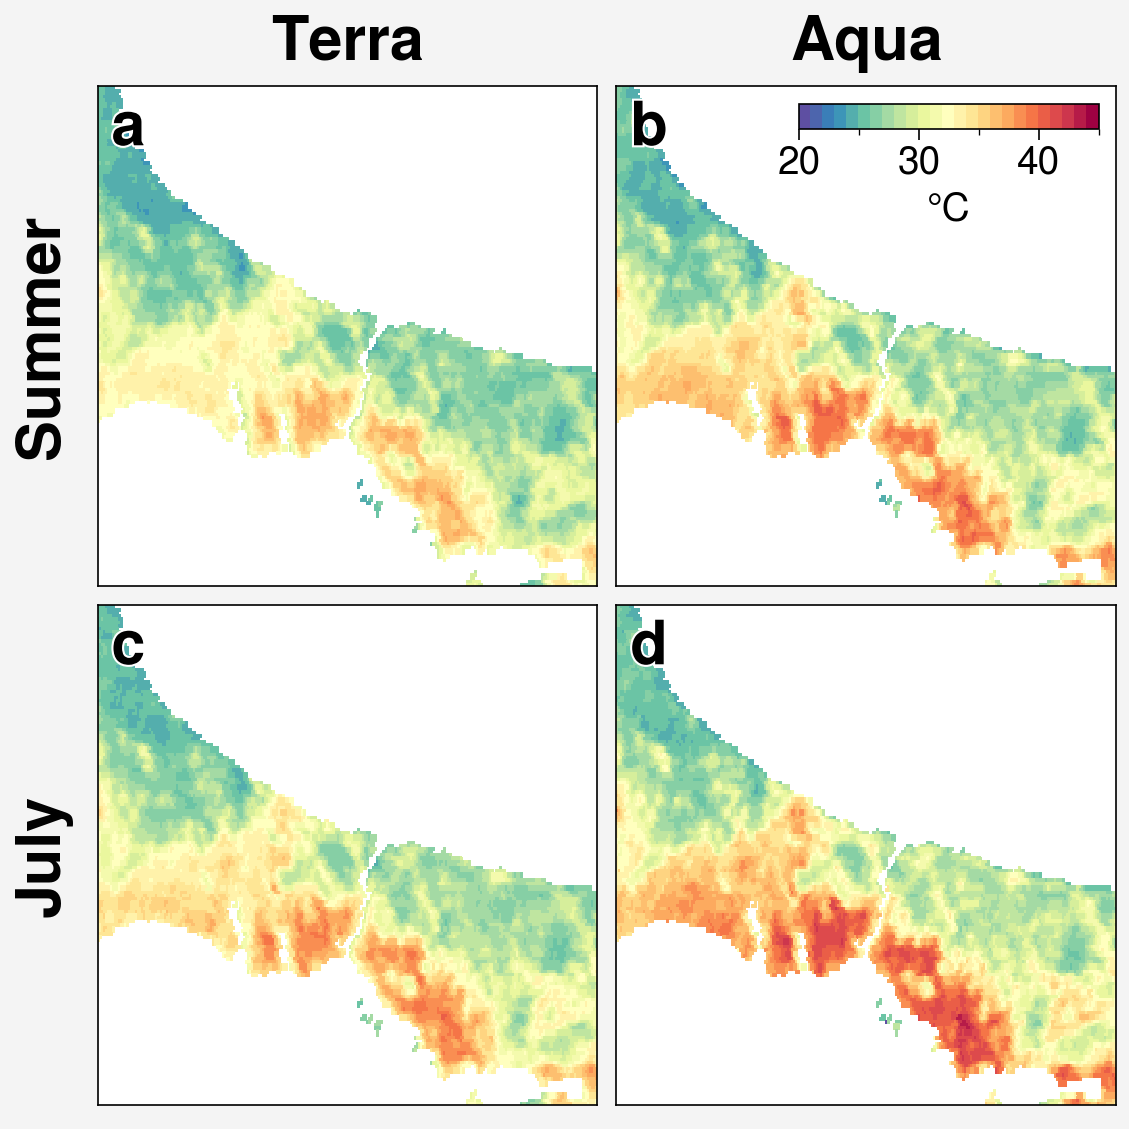

In [13]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                             includepanels=True,
                              hspace=0.76,
                              wspace=0.76,
                              sharey=3)

# format whole figure
proplot.rc['tick.labelsize'] = 20
axs.format(abcloc='ul',
          abc_kw={'size':22},
           abc=True,
          xlabel='',
          ylabel='')

axs.format(collabels=['Terra', 'Aqua'],
            rowlabels=['Summer', 'July'],
            leftlabels_kw = {'size':22},
            toplabels_kw = {'size':22}
           
                   )

# terra season
mesh = axs[0].pcolormesh(modis_terra_season[1][x_dim], 
                        modis_terra_season[1][y_dim],#[::-1],
                        modis_terra_season[1], 
                        cmap = cmap,
                        linewidth = 0.8,
                        norm=norm,
                        zorder = 0.2,
                        alpha=1)

# aqua season
mesh = axs[1].pcolormesh(modis_aqua_season[1][x_dim], 
                        modis_aqua_season[1][y_dim],#[::-1],
                        modis_aqua_season[1], 
                        cmap = cmap,
                        linewidth = 0.8,
                        norm=norm,
                        zorder = 0.2,
                        alpha=1)

# terra month
mesh = axs[2].pcolormesh(modis_terra_month[6][x_dim], 
                        modis_terra_month[6][y_dim],#[::-1],
                        modis_terra_month[6], 
                        cmap = cmap,
                        linewidth = 0.8,
                        norm=norm,
                        zorder = 0.2,
                        alpha=1)

# aqua month
mesh = axs[3].pcolormesh(modis_aqua_month[6][x_dim], 
                        modis_aqua_month[6][y_dim],#[::-1],
                        modis_aqua_month[6], 
                        cmap = cmap,
                        linewidth = 0.8,
                        norm=norm,
                        zorder = 0.2,
                        alpha=1)

for i in range(4):
    axs[i].format(yreverse = True)
    axs[i].set_xticks([])
    axs[i].set_yticks([])    
    
# colorbars
axs[1].colorbar(mesh,
                 label='°C',
                 ticks = ticks,
                 loc='ur', length=12,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=1,
                 labelsize = 14,
                 ticklabelsize = 14,
                 frame=False,
                )

#save figure
plt.savefig(r'pictures/modis_uhi_analysis_2017.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)